<a href="https://colab.research.google.com/github/felipesebben/ML_hands_on_notes/blob/master/projects/Ch02-end2end-CA_house_price_prediction/02_end_to_end_ML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Chapter 2 | <b>End-to-end ML Project</b></h1>
<p>Here's our first ML project following Chapter 2's notes. Let's make sure everything goes smoothly and follow the book's instructions carefully!</p>
<h2>Setup</h2>
<h3>Import libraries</h3>

In [1]:
# Make sure we're running Python 3.7 or above
import sys
assert sys.version_info >= (3, 7)

# Make sure we're running Scikit-Learn 1.0.1 or above
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Import other libraries
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
from zlib import crc32
from sklearn.model_selection import train_test_split

<h2><b>Get</b> the data</h2>
<p><b>Assignment</b>: predict median house values in Californian districts given a number of features from these districts.</p>
<h3><b>Download</b> the data</h2>
<p>Let's prepare a function to download and decompress the dataset. This is a good practice when you need to regularly access changing data.</p>

In [2]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

<h3>Take a <b>quick look</b> at the data structure</h3>

In [3]:
housing = load_housing_data()

In [4]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [5]:
housing.shape

(20640, 10)

In [6]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<p>We have 10 features/attributes and 20640 observations/instances. We can use <code>.info()</code> to get a more insightful look at the dataset:</p>

In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


<p>We can make an observation about the missing values for <code>total_bedrooms</code>. We also see that <code>ocean_proximity</code> is of type <code>object</code>, which stores any kind of Python object, but we can tell we are looking at a text attribute - more specifically, a categorical value. Let's use <code>.value_counts()</code> to get the count of categories for this variable:</p>

In [8]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

<p>We have <b>five</b> different categories. We can take a look at our numerical features now using <code>.describe()</code>:</p>

In [9]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [10]:
housing["housing_median_age"].std()/housing["housing_median_age"].mean()

0.4394477408338836

<p>We can get a few quick insights into our data. For instance, regarding the dispersion of <code>housing_median_age</code>, we can tell that it is not very dispersed after calculating the coefficient of variation (code above), as it fell under 1. We know that 25% of the houses have a median age under 18, that 50% of them are under 29 years old, and that 75% of them are under 37 years old. We can apply the same thinking to observe other relevant features.</p>
<p>The following cells were created to store images of the graphs.</p>

In [11]:
IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

In [12]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    """
    Save figures as high resolution PNGs.
    """
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [13]:
%matplotlib inline

<p>Now, let's plot a histogram for each numerical variable to get more information on the distribution of our dataset:</p>

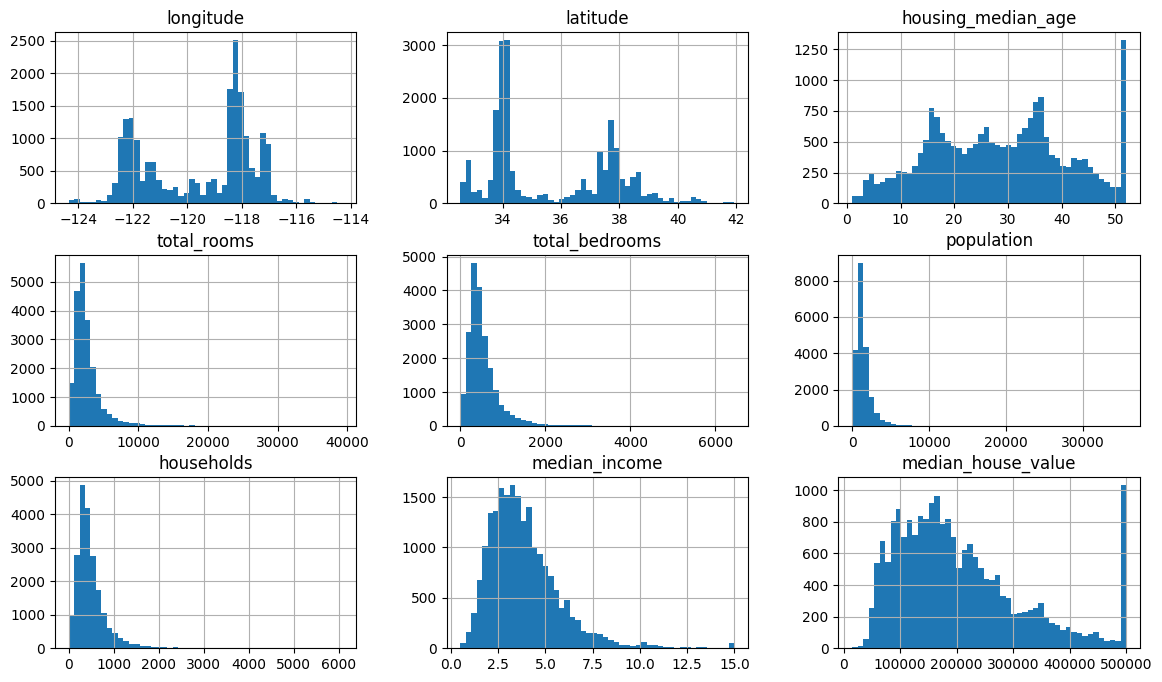

In [14]:
housing.hist(bins=50, figsize=(14, 8))
plt.show()

<p>Observations on these distributions:</p>
<ul>
    <li><code>median_income</code>: it does not seem to be in USD. It has been scaled and capped at <code>15</code> for higher median incomes and <code>0.5</code> for lower median incomes. The numbers represent <b>tens of thousands of USD</b>.</li>
    <li><code>median_house_age</code> and <code>median_house_value</code> have also been capped. Notice how the ending bins are disproportionally larger than the rest.</li>
        <ul>
            <li>The latter might be an issue, as it is our <b>target attribute</b>. If our team needs precise predictions beyond USD500,000m then we either:</li>
            <ul>
                <li>Collect proper labels for the capped districts.</li>
                <li>Remove capped districts from the dataset.</li>
            </ul>
        </ul>
    <li>There is an issue with <b>different scales</b>.</li>
    <li>Histograms are <b>rightly skewed</b>. This distribution may affect the abilities of ML to detect patterns.</li>
</ul>



<h2><font color="red"><b>WARNING!</b></font></h2>
Now it's the time to create a test set, put it aside, and <font color="dark red"><b>never look at it</b></font>!
<hr>
<h2>Create a <b>test set</b></h2>
<p>Basically, we need to pick <b>20%</b> of the dataset (this percentage may be smaller if the dataset is very large).</p>

In [15]:
def shuffle_and_split_data(data, test_ratio):
    """
    Shuffle the indices, split them into test and training sets based on a test ratio.
    """
    shuffled_indices = np.random.permutation(len(data)) # generate random permutation from 0 to length of data
    test_set_size = int(len(data) * test_ratio) # multiplies length of data by assigned percentage
    test_indices = shuffled_indices[:test_set_size] # assign the first elements
    train_indices = shuffled_indices[test_set_size:] # assign remaining indices
    return data.iloc[train_indices], data.iloc[test_indices]


In [16]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set)

16512

In [17]:
len(test_set)

4128

<p>Using this code, every time we run our notebook, we'll get a different test set. This is not desirable, as we don't want to see the whole dataset. To avoid this behavior, we can set the random number generator's seed before calling <code>np.random.permutation()</code>. 

In [18]:
np.random.seed(42)

<p>This will not work, however, after you get an updated dataset. Instead, you <i>can</i> do, instead, is to use each instance's identifier to decide if it should not go in the test set. This would require that instances have unique and immutable identifiers. For instance, we could compute a hash of each instance's id and put that instance in the test set if the hash is lower or equal to 20% of the max hash value. The test set will remain consistent across multiple runs even if the dataset is updated. The new test set will contain 20% of the new instances but it will not contain any instance that was previously in the training set.</p>

In [19]:
def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32


def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]


<p>Because the dataset does not present an id column, we will use the row index as an id.</p>

In [20]:
housing_with_id = housing.reset_index() # adds an index column by keeping default drop=False

train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

<p>When you use this method, you must ensure that new data gets appended to the end of the dataset and that no row ever gets deleted. If this is not possible, using a stable feature - aka, one that does not change - is an alternative.In our case, a district's latitude and longitude could be used as unique ids:</p>

In [21]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]

train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

<p>Scikit-Learn also provides a few functions that allow us to split datasets in different ways. <code>train_test_split()</code> does the same thing as our function <code>shuffle_and_split_data()</code> and includes a couple of additional features. You can use the parameter <code>random_state</code>, which allows you to set the random generator seed, just as we did with <code>np.random.seed()</code>. Also, you can also pass multiple datasets with an identical number of rows, and split them on the same indices:</p>

In [22]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

<p>If the dataset is large and has many attributes, a random sample is just fine. However, when this is not the case, we can run the risk of introducing a <b>sampling bias</b>. This is particularly true when the sample we are running must be representative of the entire population. For example, when conducting a survey, one must take into consideration the male-female ratio in a given country to avoid an over-representative sample. This is called <b>stratified sampling</b>: we divide the population into <b>strata</b>, and the right number of instances are sampled from each stratum to make sure that the test set is representative.</p>
<p>If we want to find the probability that a random sample of 1000 people conains less than 48.5% femail or more than 53.5% when the population's female ratio is 51.1%, we use the <b>binomial distribution</b>. The <code>cdf()</code> method of the binomial distribution gives us the probability that the number of females will be equal or less than the given value:</p>


In [23]:
from scipy.stats import binom

sample_size = 1000
ratio_female = 0.511
prob_too_small = binom(sample_size, ratio_female).cdf(485 - 1)
prob_too_large = 1 - binom(sample_size, ratio_female).cdf(535)
print(prob_too_small + prob_too_large)

0.10736798530929913


<p>Likewise, we can run a simulation to get a similar result:</p>

In [24]:
np.random.seed(42)

samples = (np.random.rand(100_000, sample_size) < ratio_female).sum(axis=1)
((samples < 485) | (samples > 535)).mean()

0.1071

<p>In our case, considering that the experts told us that the median income is a very important attribute to predict median housing prices, we want to be sure that the test set is representative of the various categories of incomes in the whole dataset. The median income is a <b>continuous, numerical</b> attribute and therefore we must create an <b>income category attribute</b>. </p>
<p>We know that most median income values are clustered around 1.6 to 6 (or &#36;15k to &#36;60k). We know, however, that some values fall below or above this interval. It is important to have a sufficient number of observations for each stratum, otherwise the estimate of a stratum's relevance may be biased. In other words, we should <b>not</b> have too many strata, and each strata should be <b>large enough</b>. We can use <code>pd.cut()</code> to create <b>five</b> categories with different ranges considering a 1.5 interval:</p>

In [25]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4,5])

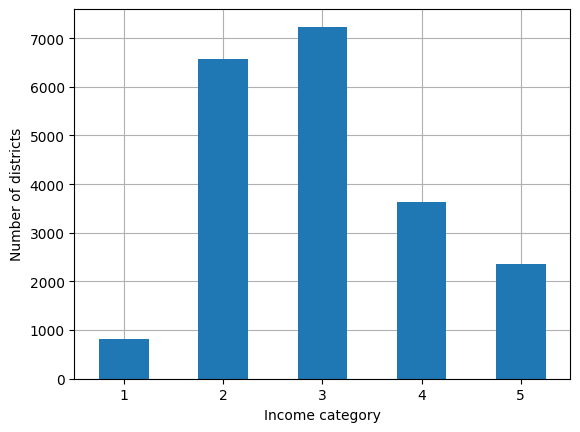

In [32]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)

# adjust the zorder of the grid lines to be displayed behind the bars
plt.gca().set_axisbelow(True)

plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()


<p>This categorization allows us to do stratified sampling based on the income category. We can now do a stratified sampling based on this variable, and Scikit-Learn provides some splitter classes in the <code>sklearn.model_selection</code> package. Each of these has a <code>split()</code> method that returns an iterator over different training/test splits of the same data.</p>
<p><code>split()</code> actually yields the training and test <b>indices</b> and <i>not</i> the actual data. Splitting the dataset multiple times will be helpful in upcoming tasks. The following code generates 10 different stratified splits of the same dataset:</p>

In [27]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []

for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

<p>We just imported the class <code>StratifiedShuffleSplit</code> from the <code>sklearn.model_selection</code> package. Then, we created a variable <code>splitter</code> that uses this class, defining the number of splits, the proportion of the dataset to be used, and the randomness of the sample. We created an empty list to store the stratified splits. Following, we apply a for loop that passes the function <code>.split()</code>. which splits the dataset into a training and test set, returning their respective indices. They are assigned to different variables, which are then appended to the empty list as two different sets.</p>
<p>For now, we can use the first split only:</p>

In [28]:
strat_train_set, strat_test_set = strat_splits[0]

<p>We can also cut some slack and use <code>train_test_split()</code> with the stratify argument passed on it:</p>

In [29]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

<p>To see if our code has worked properly, we can look at the income category proportions in the test set:</p>

In [30]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

<p>By comparing these results with the bar chart, we can safely say that it has worked. We can also measure proportions in the full dataset:</p>

In [31]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set= train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()

compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] -1)
compare_props["Rand. Error %"] = (compare_props["Random %"] / 
                                  compare_props["Overall %"] -1)

(compare_props * 100).round(2)


,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


<p>What do we get out of this comparison between stratified versus purely random sampling methods? Well, the test set that was created using the former has income category proportions <b>almost identical</b> to those in the overall dataset. The latter, meanwhile, returned <b>higher percentage errors</b>, which reflects the problem of purely random sampling returning skewed results.</p>
<p>Since we won't be using <code>income_cat</code> no more, we can go ahead and just drop it out of our dataset.</p>

In [35]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

<p>Spending some time on test set generation is important, as it is often <b>neglected</b>. Also, those concepts will help us when discussing cross-validation. We can move on and explore our data!</p>
<hr>
<h2><b>Explore</b> and <b>Visualize</b> the Data to <b>Gain Insights</b>
<p><b>Goal</b>: to go into a little more depth and understand our dataset.</p>
<p>We should make some important notes here. First, we must be sure that we will be exploring <b>only</b> the <b>training set</b>. In addition, in case our set is too large, we must also <b>sample it</b>; we won't be doing this now, as our set is fairly small. Second, because we will be performing several manipulation procedures on our data, we should also <b>make a copy</b> of it and work on it.</p>


In [36]:
housing = strat_train_set.copy()

<h3>Visualizing <b>Geographical Data</b></h3>
<p>Let's create a scatterplot using the geographical information available in our dataset:</p>

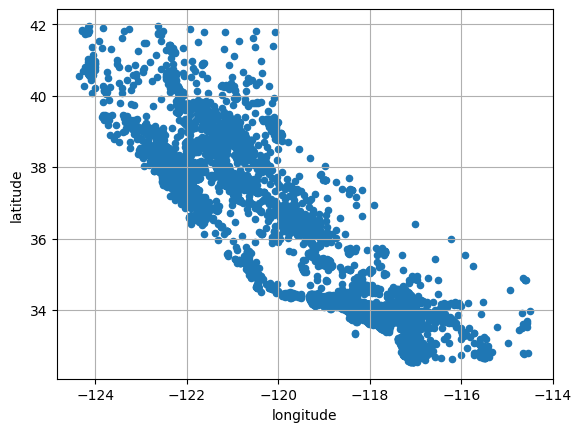

In [40]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)

plt.show()

<p>To make our chart more meaningful, we can adjust some parameters of <code>.plot()</code>. Let's set <code>alpha</code> to <code>0.2</code> and move our grid to the back.</p>

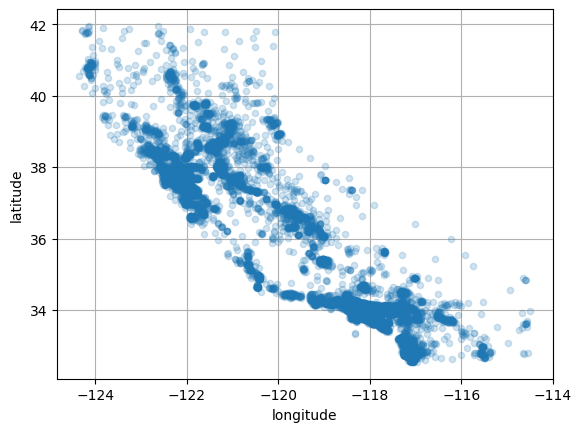

In [41]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.gca().set_axisbelow(True)
plt.show()

<p>We can now see the <b>high-density areas</b> such as Bay Area (around Los Angeles and San Diego), as well as other regions in the Central Valley (around Sacramento and Fresno).</p>
<p>We can refine our visualization even more. Let's 